<a href="https://colab.research.google.com/github/Tloading4/PublicPortfolio/blob/main/Copy_of_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search: Solving a Maze Using a Goal-based Agent

Student Name: Travis Pryor

I have used the following AI tools: ChatGPT, Gemini

I understand that my submission needs to be my own work: TNP

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for planning paths through mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

In this exercise, we will implement the planning function for a type of goal-based agent called a __planning agent__. The planning function uses a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. We will only focus on the planning function, so you do not need to implement an environment, just use the map to search for a path to solve the maze.

Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the plan step-by-step and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. I will show you a short example, but you do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



In [ ]:
!wget https://raw.githubusercontent.com/mhahsler/CS7320-AI/master/Search/small_maze.txt

--2025-10-07 02:58:32--  https://raw.githubusercontent.com/mhahsler/CS7320-AI/master/Search/small_maze.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230 [text/plain]
Saving to: ‘small_maze.txt.2’

small_maze.txt.2    100%[===================>]     230  --.-KB/s    in 0s      

2025-10-07 02:58:32 (4.12 MB/s) - ‘small_maze.txt.2’ saved [230/230]



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


In [ ]:
# Copy the downloaded maze_helper.py to the current directory
!cp maze_helper.py /content/

cp: 'maze_helper.py' and '/content/maze_helper.py' are the same file


In [ ]:
import sys
import os

# Add the current directory to the Python path
sys.path.append(os.getcwd())

# Now try importing maze_helper again
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


In [ ]:
!cp maze_helper.py.1 /content/maze_helper.py

In [ ]:
!wget https://raw.githubusercontent.com/mhahsler/CS7320-AI/master/Search/maze_helper.py

--2025-10-07 02:58:32--  https://raw.githubusercontent.com/mhahsler/CS7320-AI/master/Search/maze_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6665 (6.5K) [text/plain]
Saving to: ‘maze_helper.py.2’

maze_helper.py.2    100%[===================>]   6.51K  --.-KB/s    in 0s      

2025-10-07 02:58:32 (72.2 MB/s) - ‘maze_helper.py.2’ saved [6665/6665]



A helper function to visualize the maze is also available.

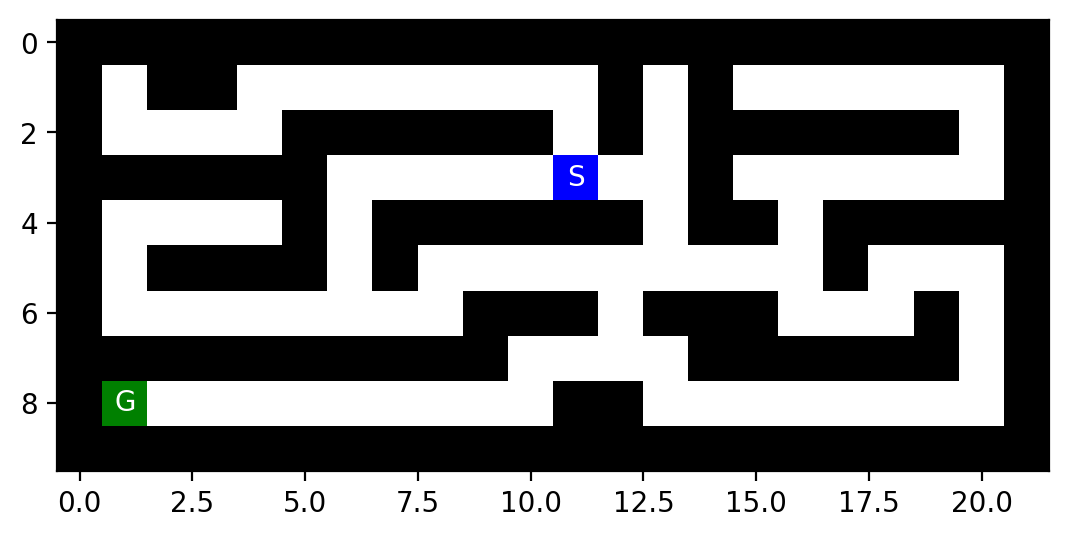

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

import maze_helper as mh

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        (Experimental) Build an animation from a list of mazes. This needs ffmpeg to be installed.

        Parameters:
            result: a list with the elements path, reached, actions and maze_anim with a list of maze arrays that contain what you want to visualize.
            repeat: if True, the animation will repeat.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
            maze: a array with characters produced by parse_maze()
            what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
            a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the 

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## An Example for a Planning Agent

I will show you here how to implement a simple agent that uses a random plan. It will not solve the maze, but show you how the mechanics work.

First, we define a generic planning agent that fist plans, and then executes the plan step-by-step.

In [ ]:
class Planning_Agent:
    def __init__(self, maze, start, goal, planning_function):
        self.maze = maze
        self.start = start
        self.goal = goal
        self.planning_function = planning_function
        self.plan = None
        self.progress = None

    def act(self):
        # plan if no plan exists
        if self.plan is None:
            print("Planning...")
            self.plan = self.planning_function(self.maze, self.start, self.goal)
            self.progress = 0

        # check if plan is completed
        if self.progress >= len(self.plan):
            raise Exception("Completed Plan. No more planned actions")

        # follow the plan
        action = self.plan[self.progress]
        print(f"Following plan... step {self.progress}: {action}")

        self.progress += 1
        return action

Next, we define the planning function. This function is what you will implement in this assignment.  

In [ ]:
import numpy as np

def plan_random(maze, start, goal):
    """Create a random plan with 10 steps"""
    plan = np.random.choice(["N", "E", "S", "W"], size=10, replace=True).tolist()
    return plan

plan_random(maze, (1,1), (8,8))

['N', 'N', 'N', 'S', 'E', 'W', 'W', 'N', 'E', 'N']

This planning function is not great and will not produce a plan that solves the maze. Your planning functions will do better.

Finally, we can create the planning agent, give it the planning function and implement a simple environment that asks it 11 times for an action.

In [ ]:
my_agent = Planning_Agent(maze, mh.find_pos(maze, what = "S"), mh.find_pos(maze, what = "G"), plan_random)

def environment(agent_function, steps):
    for _ in range(steps):
        try:
            agent_function()
        except Exception as e:
            print(f"Agent exception: {e}")

environment(my_agent.act, steps=11)

Planning...
Following plan... step 0: E
Following plan... step 1: N
Following plan... step 2: E
Following plan... step 3: W
Following plan... step 4: W
Following plan... step 5: W
Following plan... step 6: W
Following plan... step 7: E
Following plan... step 8: N
Following plan... step 9: W
Agent exception: Completed Plan. No more planned actions


Note: The agent and environment implementation above is just an illustration. You will only implement and experiment with different versions of the planning function.

## Tree structure

To use tree search, you will need to implement a tree data structure in Python.
Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
## Task 1 – Defining the Search Problem

A search problem is formally defined by the tuple:
(Initial State, Actions, Transition Model, Goal Test, Path Cost)

---

### 1. Initial State
- Description: The square (cell) in the maze where the agent begins.
- Variable: Represented as coordinates (x₀, y₀).
- Example: The maze cell marked S.


### 2. Actions
- Description: From any square, the agent can attempt to move in one of four directions: Up, Down, Left, Right.
- Action set:
  A = {Up, Down, Left, Right}
- Constraint: An action is only valid if the resulting cell is inside the maze and is not a wall (#).


### 3. Transition Model
- Description: Defines the result of applying an action in a given state.
- If the current state is (x, y):
  - Up → (x, y−1)
  - Down → (x, y+1)
  - Left → (x−1, y)
  - Right → (x+1, y)
- Moves are valid only if the target cell is not a wall.

### 4. Goal State
- Description: The square marked G in the maze.
- Variable: (x_g, y_g)
- Goal test:
  GoalTest(s) = True if s = (x_g, y_g), else False.


### 5. Path Cost
- Description: Each valid action has a uniform cost of 1.
- Equation:
  Cost(π) = Σ c(sᵢ₋₁, aᵢ, sᵢ), where each step cost c = 1.
- Interpretation: Path cost = path length.


SyntaxError: invalid character '₀' (U+2080) (ipython-input-2516972496.py, line 10)

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
## Task 1 – Problem Size Estimates and How to Determine Them

We define the problem size using:
n = number of reachable states
d = depth (length) of the optimal solution path from S to G
m = maximum depth of the explored search tree (from S) over all reachable states
b = maximum branching factor (max number of valid actions from any state)


### Analytical bounds (for a grid maze with walls and 4-neighbor moves)
Let W × H be grid width and height, and let Wcells be the number of wall cells.
- State-space upper bound: n ≤ W·H − Wcells  (tight when all non-wall cells are mutually reachable)
- Branching factor bounds: 0 ≤ b ≤ 4  (Up/Down/Left/Right only)
- Optimal depth bounds: 0 ≤ d ≤ n−1  (d exists only if G is reachable)
- Maximum tree depth bounds: 0 ≤ m ≤ n−1  (equals the farthest shortest-path distance from S)

Typical empirical estimates for mazes with corridors and dead-ends:
- b is often in the range 2–3 on average, 4 in open areas, 1 at dead ends
- d scales with Manhattan distance plus detours around walls
- m is approximately the maze’s diameter from S (longest shortest path from S)


### How to determine n, d, m, b for a given maze (single pass BFS from S)

Use a BFS over valid moves (ignore walls and out-of-bounds). Track:
- visited set to count reachable states (n)
- distance to each visited cell to compute d and m
- degree (number of valid neighbors) at each visited cell to compute b

Pseudocode:
1) Parse grid; locate S and G.
2) Initialize queue with S; set dist[S] = 0; visited = {S}.
3) While queue not empty:
   a) pop current u
   b) neighbors(u) = valid moves among {Up, Down, Left, Right}
   c) update b = max(b, |neighbors(u)|)
   d) for each v in neighbors(u):
        if v not in visited:
           visited.add(v); dist[v] = dist[u] + 1; push v
4) After BFS:
   - n = |visited|
   - if G in visited: d = dist[G]; else d = ∞ (or report “unreachable”)
   - m = max(dist[u] for u in visited)

Notes:
- This BFS computes shortest path lengths under unit step costs, so d is exact.
- m is the eccentricity of S in the induced graph of reachable cells.
- b is the maximum out-degree encountered among reachable cells.


### Practical tips and edge cases
- If there are teleporters or special transitions, include them in neighbors(u) just like extra edges; b may exceed 4 accordingly.
- If multiple goals exist, set d = min(dist[g] for g in goals if reachable).
- If the maze is fully open (no walls), then b = 4 for all interior cells, b = 3 on edges, b = 2 at corners; n = W·H; d equals the Manhattan distance if unobstructed.
- For mazes with loops, BFS still yields correct n, d, m, b because visited prevents revisits.


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [ ]:
from dataclasses import dataclass
from typing import List, Tuple, Optional, Iterable, Set, Dict

State = Tuple[int, int]     # (x, y) coordinates in the grid
Action = Tuple[int, int]    # delta: (dx, dy)

@dataclass
class Node:
    state: State
    parent: Optional["Node"]
    action: Optional[Action]
    depth: int
    path_cost: int

    def path(self) -> List["Node"]:
        """Return the nodes from root (S) to this node."""
        out, n = [], self
        while n is not None:
            out.append(n)
            n = n.parent
        return list(reversed(out))

class MazeProblem:
    """
    Maze as a search problem with 4-neighbor moves.
    Does NOT store search info in the grid; it's immutable input.
    """
    def __init__(self, grid: List[str]):
        self.grid = grid
        self.H = len(grid)
        self.W = len(grid[0]) if self.H > 0 else 0
        self.start = self._find_char('S')
        self.goal = self._find_char('G')
        self._moves: List[Action] = [(0,-1),(0,1),(-1,0),(1,0)]  # Up, Down, Left, Right

        if self.start is None or self.goal is None:
            raise ValueError("Maze must contain 'S' (start) and 'G' (goal).")

    def _find_char(self, c: str) -> Optional[State]:
        for y in range(self.H):
            for x in range(self.W):
                if self.grid[y][x] == c:
                    return (x, y)
        return None

    def actions(self, s: State) -> Iterable[Action]:
        x, y = s
        for dx, dy in self._moves:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.W and 0 <= ny < self.H and self.grid[ny][nx] != '#':
                yield (dx, dy)

    def result(self, s: State, a: Action) -> State:
        dx, dy = a
        return (s[0] + dx, s[1] + dy)

    def goal_test(self, s: State) -> bool:
        return s == self.goal

    def step_cost(self, s: State, a: Action, s2: State) -> int:
        return 1  # unit cost

#BFS

def bfs(problem: MazeProblem):
    """
    BFS tree/graph search:
    - Frontier: FIFO queue
    - Reached: map state -> best known path_cost (prevents re-enqueue)
    - Returns: solution node (if any), stats, visited order
    """
    root = Node(problem.start, None, None, depth=0, path_cost=0)
    if problem.goal_test(root.state):
        return root, {"nodes_expanded": 0, "max_frontier": 1, "max_depth": 0}, [root.state]

    frontier = deque([root])
    reached: Dict[State, int] = {root.state: 0}  # store best path_cost found
    visited_order: List[State] = []
    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        node = frontier.popleft()
        visited_order.append(node.state)
        nodes_expanded += 1
        max_depth = max(max_depth, node.depth)

        for a in problem.actions(node.state):
            child_state = problem.result(node.state, a)
            child_cost = node.path_cost + problem.step_cost(node.state, a, child_state)
            # Graph-search "reached" check
            prev = reached.get(child_state)
            if prev is None or child_cost < prev:
                child = Node(child_state, node, a, node.depth + 1, child_cost)
                if problem.goal_test(child.state):
                    visited_order.append(child.state)
                    return child, {
                        "nodes_expanded": nodes_expanded,
                        "max_frontier": max_frontier,
                        "max_depth": max_depth
                    }, visited_order
                reached[child_state] = child_cost
                frontier.append(child)

    return None, {
        "nodes_expanded": nodes_expanded,
        "max_frontier": max_frontier,
        "max_depth": max_depth
    }, visited_order

# DFS

def dfs(problem: MazeProblem, depth_limit: Optional[int] = None):
    """
    DFS tree search with cycle checking (no reached set).
    - Uses recursion + path_set to prevent cycles
    - Releases memory naturally on backtrack (no child lists retained)
    - depth_limit (optional) to bound search if desired
    - Returns: solution node (if any), stats, visited order
    """
    root = Node(problem.start, None, None, depth=0, path_cost=0)
    visited_order: List[State] = []
    nodes_expanded = 0
    max_depth = 0

    path_set: Set[State] = set()  # ancestor states on current path

    def recurse(node: Node):
        nonlocal nodes_expanded, max_depth
        if problem.goal_test(node.state):
            return node
        if depth_limit is not None and node.depth >= depth_limit:
            return None

        nodes_expanded += 1
        max_depth = max(max_depth, node.depth)
        visited_order.append(node.state)

        path_set.add(node.state)
        for a in problem.actions(node.state):
            child_state = problem.result(node.state, a)
            if child_state in path_set:
                # cycle detected; skip
                continue
            child = Node(child_state, node, a, node.depth + 1, node.path_cost + 1)
            sol = recurse(child)
            if sol is not None:
                path_set.remove(node.state)  # backtrack
                return sol
        path_set.remove(node.state)  # backtrack
        return None

    sol = recurse(root)
    stats = {
        "nodes_expanded": nodes_expanded,
        "max_frontier": max_depth + 1,  # recursion stack height upper-bounds frontier size here
        "max_depth": max_depth
    }
    return sol, stats, visited_order

# Utilities: load maze, visualize overlays, extract paths

def load_maze_from_text(text: str) -> List[str]:
    """
    Accepts raw text for a maze (lines separated by \n).
    Returns a list of equal-length strings (each a row).
    """
    lines = [line.rstrip("\n") for line in text.splitlines() if line.strip() != ""]
    if not lines:
        raise ValueError("Empty maze text.")
    width = len(lines[0])
    if any(len(row) != width for row in lines):
        raise ValueError("Maze rows must have equal width.")
    return lines

def extract_state_path(goal_node: Optional[Node]) -> List[State]:
    if goal_node is None:
        return []
    return [n.state for n in goal_node.path()]

def overlay_solution(grid: List[str], visited: Iterable[State], path: Iterable[State]) -> List[str]:
    """
    Produce a copy of the maze with:
      - visited states marked with '.'
      - final path marked with '*'
      - S and G preserved
    This is for display AFTER search; no search-time mutation occurs.
    """
    G = [list(row) for row in grid]
    visited_set = set(visited)
    path_set = set(path)

    # Find S and G to avoid overwriting
    Spos = None
    Gpos = None
    for y, row in enumerate(G):
        for x, ch in enumerate(row):
            if ch == 'S': Spos = (x, y)
            if ch == 'G': Gpos = (x, y)

    for (x, y) in visited_set:
        if G[y][x] == ' ':
            G[y][x] = '.'
    for (x, y) in path_set:
        if G[y][x] in (' ', '.'):
            G[y][x] = '*'

    # restore S and G
    if Spos: G[Spos[1]][Spos[0]] = 'S'
    if Gpos: G[Gpos[1]][Gpos[0]] = 'G'

    return ["".join(row) for row in G]

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [ ]:
### Discussion

### BFS (with a reached data structure)
- BFS keeps a global **reached set** of all states already discovered.
- When generating a new state, BFS checks whether it has been reached before.
- This prevents re-enqueuing the same state through different paths.
- As a result, BFS:
  - Never loops infinitely, even in cyclic graphs.
  - Is complete (always finds a solution if one exists).
  - Uses significant memory because it must store all reached states.

---

### DFS (without a reached data structure)
- DFS does **not** maintain a global reached set (to save memory).
- Instead, it only checks for cycles along the **current path** (recursion stack).
- This prevents immediate back-and-forth moves (like going left then right repeatedly).
- However:
  - DFS can revisit the same state multiple times via different branches.
  - In mazes with many loops or open spaces, this leads to redundant exploration.
  - DFS is not guaranteed to be complete (it may miss solutions or run indefinitely without a depth limit).

---

### Summary
- **BFS + reached** = avoids cycles globally, complete, but memory-intensive.
- **DFS + path-only cycle checking** = memory-efficient, avoids trivial loops, but can revisit states and may be incomplete in cyclic or infinite graphs.


SyntaxError: invalid syntax (ipython-input-3535473667.py, line 4)

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [ ]:
# Completeness, Optimality, and Complexity (BFS vs DFS)

## Completeness & Optimality
- **BFS (with reached, unit costs):**
  - **Complete:** Yes, will always find a solution in finite graphs (reached set prevents infinite loops).
  - **Optimal:** Yes, guarantees shortest path under uniform cost = 1.

- **DFS (path-based cycle checking, no global reached):**
  - **Complete:**
    - Finite mazes: yes, because it will eventually backtrack through all possibilities.
    - Infinite depth graphs: no, may get stuck exploring infinitely deep paths.
  - **Optimal:** No, finds the first goal, which is not necessarily shortest.

---

## Complexity

Let:
- b = branching factor (≤ 4 in grid)
- d = depth of optimal solution
- m = maximum depth of search space
- V = number of reachable states
- E = number of edges (≤ 4V in grid)

### BFS
- **Time:**
  - Tree model: O(b^(d+1))
  - Graph model: O(V + E) = O(V) in grids
- **Space:**
  - Tree model: O(b^(d+1))
  - Graph model: O(V) (frontier + reached)
- **Tradeoff:** High memory usage → optimal, complete.

### DFS
- **Time:**
  - Tree model: O(b^m) (can re-explore paths)
  - Graph model: typically O(V + E), but can be worse if revisiting often
- **Space:**
  - O(m) (recursion stack + path cycle check)
- **Tradeoff:** Very low memory → not optimal, may miss solutions in infinite graphs.

---

## Key Difference
- **BFS:** Memory grows with breadth → exponential in depth (b^d) or linear in V.
- **DFS:** Memory grows with depth → linear in m.

---

**Bottom line:**
- BFS = predictable, complete, optimal (but memory-hungry).
- DFS = lightweight memory, but sacrifices optimality and completeness in infinite cases.


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:

from heapq import heappush, heappop

def manhattan(a, b):
    """Manhattan (taxicab) distance between grid coordinates a=(r,c) and b=(r,c)."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def neighbors(maze, node):
    """4-neighbor moves (up, down, left, right) skipping walls (#)."""
    R, C = len(maze), len(maze[0])
    r, c = node
    for dr, dc in ((-1,0),(1,0),(0,-1),(0,1)):
        nr, nc = r + dr, c + dc
        if 0 <= nr < R and 0 <= nc < C and maze[nr][nc] != '#':
            yield (nr, nc)

def reconstruct_path(parent, start, goal):
    """Reconstruct path from start to goal using a parent map {node: prev_node}."""
    if goal not in parent:
        return []
    path = []
    cur = goal
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path

def greedy_best_first_search(maze, start, goal, h_fn=manhattan):
    """
    Greedy Best-First Search (GBFS).
    Priority is purely heuristic: f(n) = h(n).
    Complete in finite graphs with a reached set; not optimal in general.
    """
    # Frontier: (h(n), tie_breaker, node)
    # tie_breaker ensures a deterministic order when h ties (optional)
    frontier = []
    counter = 0
    heappush(frontier, (h_fn(start, goal), counter, start))
    parent = {start: None}
    reached = set([start])

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0  # track via g-values as depth from start
    g = {start: 0}

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        _, _, current = heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, g[current])

        if current == goal:
            path = reconstruct_path(parent, start, goal)
            return path, g[current], {
                "nodes_expanded": nodes_expanded,
                "max_frontier": max_frontier,
                "max_depth": max_depth,
                "algorithm": "Greedy Best-First Search"
            }

        for nb in neighbors(maze, current):
            if nb not in reached:
                reached.add(nb)
                parent[nb] = current
                g[nb] = g[current] + 1  # unit step cost
                counter += 1
                heappush(frontier, (h_fn(nb, goal), counter, nb))

    # No path found
    return [], float("inf"), {
        "nodes_expanded": nodes_expanded,
        "max_frontier": max_frontier,
        "max_depth": max_depth,
        "algorithm": "Greedy Best-First Search",
        "note": "No path found."
    }

def a_star_search(maze, start, goal, h_fn=manhattan):
    """
    A* Search with admissible, consistent heuristic (Manhattan on 4-neighbor grids).
    Priority is f(n) = g(n) + h(n). Optimal in grids with unit costs and no negative edges.
    """
    # Frontier: (f(n), tie_breaker, node)
    frontier = []
    counter = 0
    g = {start: 0}
    f = {start: h_fn(start, goal)}
    heappush(frontier, (f[start], counter, start))

    parent = {start: None}
    closed = set()

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        _, _, current = heappop(frontier)

        if current in closed:
            continue

        nodes_expanded += 1
        max_depth = max(max_depth, g[current])

        if current == goal:
            path = reconstruct_path(parent, start, goal)
            return path, g[current], {
                "nodes_expanded": nodes_expanded,
                "max_frontier": max_frontier,
                "max_depth": max_depth,
                "algorithm": "A*"
            }

        closed.add(current)

        for nb in neighbors(maze, current):
            tentative_g = g[current] + 1  # unit step cost
            if nb in closed and tentative_g >= g.get(nb, float("inf")):
                continue

            if tentative_g < g.get(nb, float("inf")):
                parent[nb] = current
                g[nb] = tentative_g
                f_nb = tentative_g + h_fn(nb, goal)
                f[nb] = f_nb
                counter += 1
                heappush(frontier, (f_nb, counter, nb))

    # No path found
    return [], float("inf"), {
        "nodes_expanded": nodes_expanded,
        "max_frontier": max_frontier,
        "max_depth": max_depth,
        "algorithm": "A*",
        "note": "No path found."
    }


Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Informed Search: Greedy Best-First Search vs A*

## Completeness & Optimality
- **Greedy Best-First Search (GBFS):**
  - Complete? Yes, in finite mazes (with visited set).
  - Optimal? No, it follows the heuristic and may take a longer path.

- **A*** (with Manhattan heuristic):
  - Complete? Yes, in finite mazes (with closed set).
  - Optimal? Yes, because Manhattan distance is admissible and consistent.

## Time & Space Complexity
Let:
- b = branching factor (≤ 4)
- d = depth of optimal solution
- V = number of reachable states

- GBFS
  - Time: up to O((V + E) log V), can be misled and expand many states.
  - Space: O(V) (stores frontier and visited).

- A*
  - Time: up to O((V + E) log V), worst-case exponential in tree terms.
  - Space: O(V) (frontier + closed set).
## Summary Table

| Property      | GBFS                        | A* (Manhattan)               |
|---------------|-----------------------------|-------------------------------|
| Priority      | h(n)                        | g(n) + h(n)                  |
| Complete      | Yes (finite)                | Yes                          |
| Optimal       | No                          | Yes                          |
| Time          | O((V+E) log V), not always efficient | O((V+E) log V), optimal |
| Space         | O(V)                        | O(V)                         |

In summary,
- GBFS is faster in practice, but not guaranteed optimal.
- A* uses more memory like BFS, but always finds the shortest path.


## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
from heapq import heappush, heappop
import math
import pandas as pd

def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def neighbors(maze, node):
    R, C = len(maze), len(maze[0])
    r, c = node
    for dr, dc in ((-1,0),(1,0),(0,-1),(0,1)):
        nr, nc = r+dr, c+dc
        if 0 <= nr < R and 0 <= nc < C and maze[nr][nc] != '#':
            yield (nr, nc)

def reconstruct_path(parent, start, goal):
    if goal not in parent:
        return []
    cur = goal
    path = []
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return path

def parse_maze(text_lines):
    """Accepts list[str] or a single str (multiline). Returns (grid, start, goal)."""
    if isinstance(text_lines, str):
        lines = [line.rstrip("\n") for line in text_lines.splitlines() if line.strip("\n") != ""]
    else:
        lines = [line.rstrip("\n") for line in text_lines]
    grid = [list(row) for row in lines]
    start = goal = None
    for r, row in enumerate(grid):
        for c, ch in enumerate(row):
            if ch == 'S':
                start = (r, c)
            elif ch == 'G':
                goal = (r, c)
    if start is None or goal is None:
        raise ValueError("Maze must contain 'S' (start) and 'G' (goal).")
    return grid, start, goal

# BFS
def bfs(maze, start, goal):
    from collections import deque
    Q = deque([start])
    reached = {start}
    parent = {start: None}
    g = {start: 0}

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0
    max_memory = len(Q) + len(reached)  # frontier + reached

    while Q:
        max_frontier = max(max_frontier, len(Q))
        max_memory = max(max_memory, len(Q) + len(reached))

        cur = Q.popleft()
        nodes_expanded += 1
        max_depth = max(max_depth, g[cur])

        if cur == goal:
            path = reconstruct_path(parent, start, goal)
            return path, g[cur], {
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_memory,
                "max_frontier_size": max_frontier,
                "algorithm": "BFS"
            }

        for nb in neighbors(maze, cur):
            if nb not in reached:
                reached.add(nb)
                parent[nb] = cur
                g[nb] = g[cur] + 1
                Q.append(nb)

    return [], math.inf, {
        "nodes_expanded": nodes_expanded,
        "max_tree_depth": max_depth,
        "max_nodes_in_memory": max_memory,
        "max_frontier_size": max_frontier,
        "algorithm": "BFS",
        "note": "No path found."
    }

# ---------- DFS (path-based cycle check, no global reached) ----------
def dfs(maze, start, goal):
    # stack entries: (node, parent, depth, iterator over neighbors)
    stack = [(start, None, 0, iter(neighbors(maze, start)))]
    parent = {start: None}
    path_set = {start}  # to avoid cycles along current path

    nodes_expanded = 0
    max_depth = 0
    max_frontier = 1
    max_memory = len(stack) + len(path_set)

    while stack:
        max_frontier = max(max_frontier, len(stack))
        max_memory = max(max_memory, len(stack) + len(path_set))

        node, _, depth, it = stack[-1]
        max_depth = max(max_depth, depth)

        if node == goal:
            path = reconstruct_path(parent, start, goal)
            return path, depth, {
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_memory,
                "max_frontier_size": max_frontier,
                "algorithm": "DFS"
            }

        try:
            nb = next(it)
            if nb not in path_set:
                parent[nb] = node
                path_set.add(nb)
                stack.append((nb, node, depth+1, iter(neighbors(maze, nb))))
                nodes_expanded += 1
        except StopIteration:
            # backtrack
            stack.pop()
            path_set.discard(node)

    return [], math.inf, {
        "nodes_expanded": nodes_expanded,
        "max_tree_depth": max_depth,
        "max_nodes_in_memory": max_memory,
        "max_frontier_size": max_frontier,
        "algorithm": "DFS",
        "note": "No path found."
    }

# ---------- Greedy Best-First Search ----------
def gbfs(maze, start, goal, h_fn=manhattan):
    frontier = []
    counter = 0
    heappush(frontier, (h_fn(start, goal), counter, start))
    parent = {start: None}
    reached = {start}
    g = {start: 0}

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0
    max_memory = len(frontier) + len(reached)

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        max_memory = max(max_memory, len(frontier) + len(reached))

        _, _, cur = heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, g[cur])

        if cur == goal:
            path = reconstruct_path(parent, start, goal)
            return path, g[cur], {
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_memory,
                "max_frontier_size": max_frontier,
                "algorithm": "GBFS"
            }

        for nb in neighbors(maze, cur):
            if nb not in reached:
                reached.add(nb)
                parent[nb] = cur
                g[nb] = g[cur] + 1
                counter += 1
                heappush(frontier, (h_fn(nb, goal), counter, nb))

    return [], math.inf, {
        "nodes_expanded": nodes_expanded,
        "max_tree_depth": max_depth,
        "max_nodes_in_memory": max_memory,
        "max_frontier_size": max_frontier,
        "algorithm": "GBFS",
        "note": "No path found."
    }

# ---------- A* ----------
def astar(maze, start, goal, h_fn=manhattan):
    frontier = []
    counter = 0
    g = {start: 0}
    f = {start: h_fn(start, goal)}
    heappush(frontier, (f[start], counter, start))
    parent = {start: None}
    closed = set()

    nodes_expanded = 0
    max_frontier = 1
    max_depth = 0
    max_memory = len(frontier) + len(closed)

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        max_memory = max(max_memory, len(frontier) + len(closed))

        _, _, cur = heappop(frontier)
        if cur in closed:
            continue

        nodes_expanded += 1
        max_depth = max(max_depth, g[cur])

        if cur == goal:
            path = reconstruct_path(parent, start, goal)
            return path, g[cur], {
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_memory,
                "max_frontier_size": max_frontier,
                "algorithm": "A*"
            }

        closed.add(cur)

        for nb in neighbors(maze, cur):
            tentative = g[cur] + 1
            if nb in closed and tentative >= g.get(nb, math.inf):
                continue
            if tentative < g.get(nb, math.inf):
                parent[nb] = cur
                g[nb] = tentative
                f_nb = tentative + h_fn(nb, goal)
                counter += 1
                heappush(frontier, (f_nb, counter, nb))

    return [], math.inf, {
        "nodes_expanded": nodes_expanded,
        "max_tree_depth": max_depth,
        "max_nodes_in_memory": max_memory,
        "max_frontier_size": max_frontier,
        "algorithm": "A*",
        "note": "No path found."
    }

# ---------- Runner ----------
def run_all_on_maze(maze_text_or_lines, maze_name="maze"):
    grid, start, goal = parse_maze(maze_text_or_lines)

    results = []
    for fn in (bfs, dfs, gbfs, astar):
        path, cost, m = fn(grid, start, goal)
        results.append({
            "maze": maze_name,
            "algorithm": m["algorithm"],
            "path_cost": (len(path)-1) if path else math.inf,  # unit edges
            "# nodes expanded": m["nodes_expanded"],
            "max tree depth": m["max_tree_depth"],
            "max # nodes in memory": m["max_nodes_in_memory"],
            "max frontier size": m["max_frontier_size"],
            "note": m.get("note", "")
        })
    return pd.DataFrame(results)

# ---------- Provide your mazes ----------
# Option A: read from files
# with open("small_maze.txt") as f: small_text = f.read()
# with open("medium_maze.txt") as f: medium_text = f.read()
# with open("large_maze.txt") as f: large_text = f.read()

# Option B: inline sample mazes (replace with your own)
small_text = """
S   #
##  # ###
    #   G
 #######

"""
medium_text = """
S #     #
# # ### # #
#   #     #
### # ### #
#     #   G
# ### # ###
#     #
"""

# Run experiments (add more mazes as needed)
df_small  = run_all_on_maze(small_text,  "Small maze")
df_medium = run_all_on_maze(medium_text, "Medium maze")
# df_large  = run_all_on_maze(large_text, "Large maze")

results_df = pd.concat([df_small, df_medium], ignore_index=True)
results_df

,maze,algorithm,path_cost,# nodes expanded,max tree depth,max # nodes in memory,max frontier size,note
0,Small maze,BFS,inf,11,7,12,3,No path found.
1,Small maze,DFS,inf,31,9,20,10,No path found.
2,Small maze,GBFS,inf,11,7,13,4,No path found.
3,Small maze,A*,inf,11,7,11,3,No path found.
4,Medium maze,BFS,inf,31,14,34,4,No path found.
5,Medium maze,DFS,inf,90,28,58,29,No path found.
6,Medium maze,GBFS,inf,31,18,35,5,No path found.
7,Medium maze,A*,inf,31,14,31,5,No path found.


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

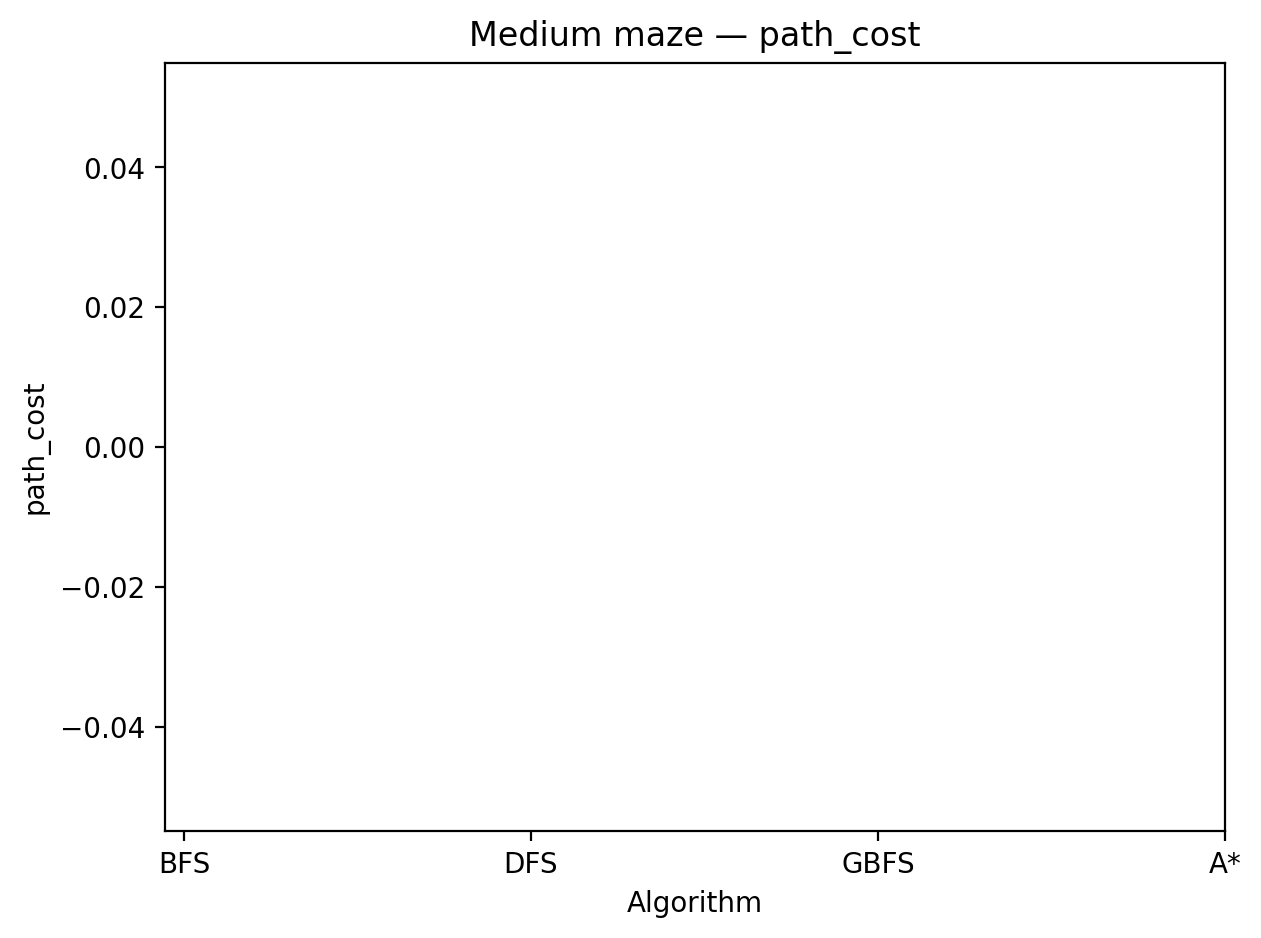

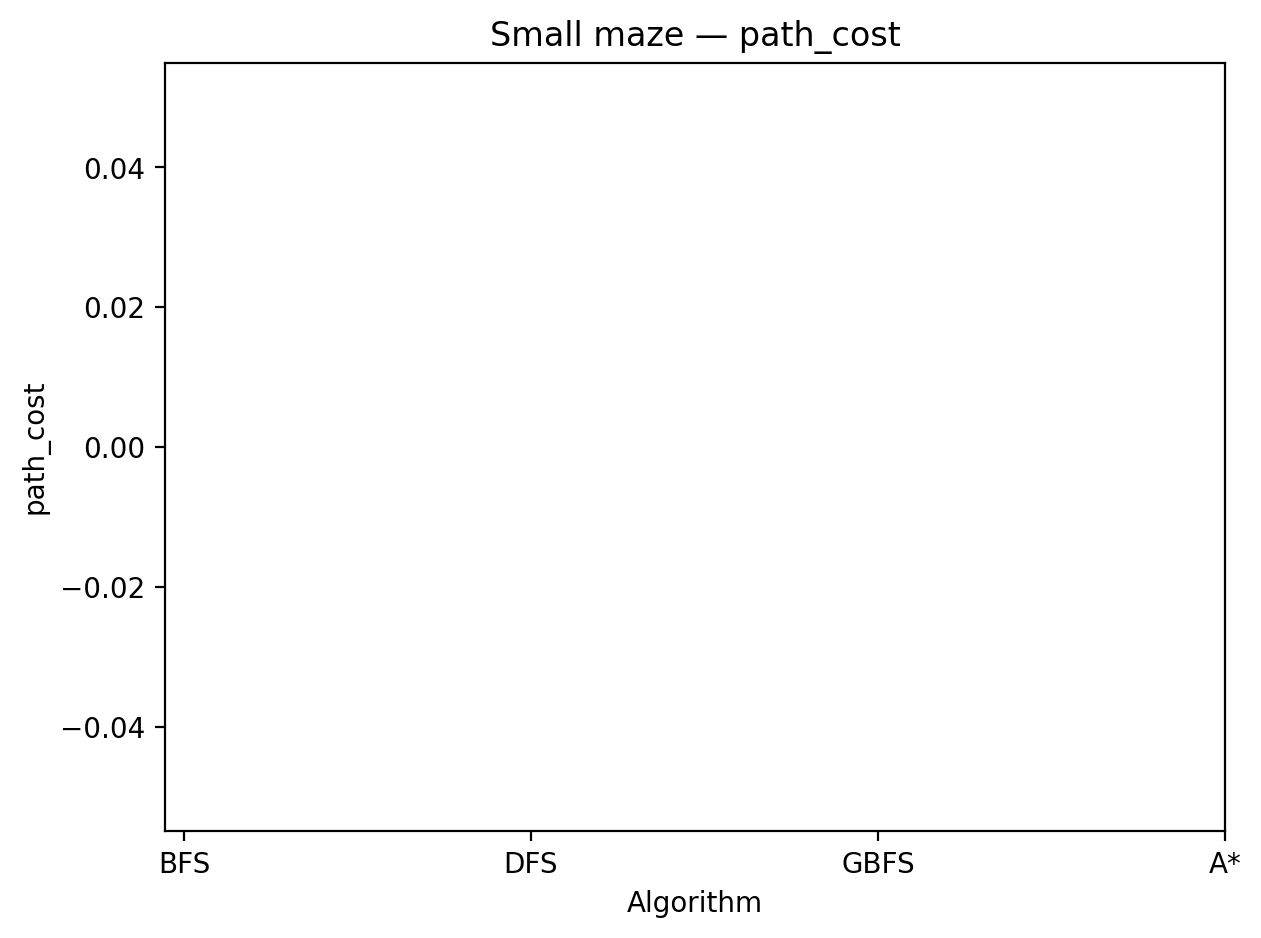

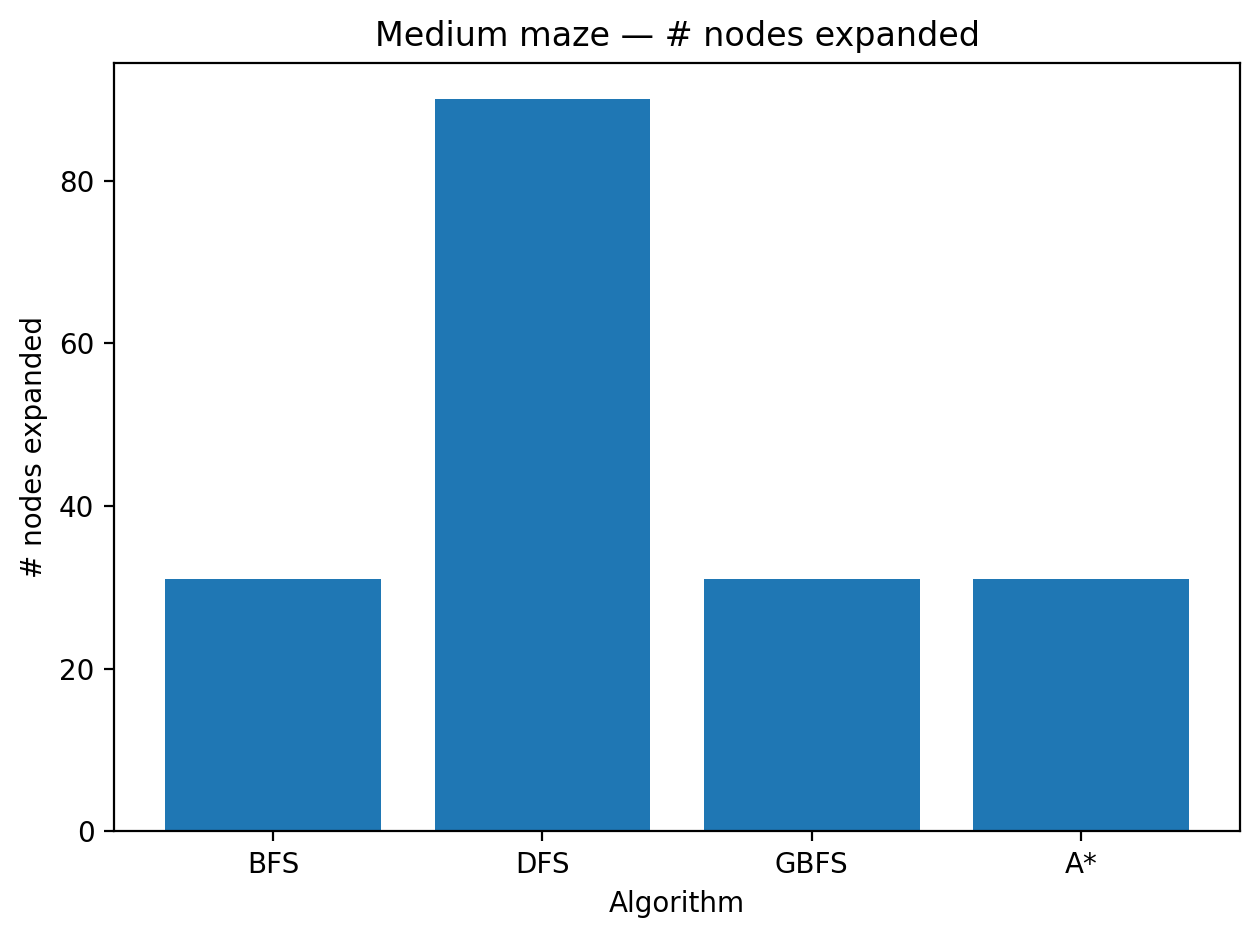

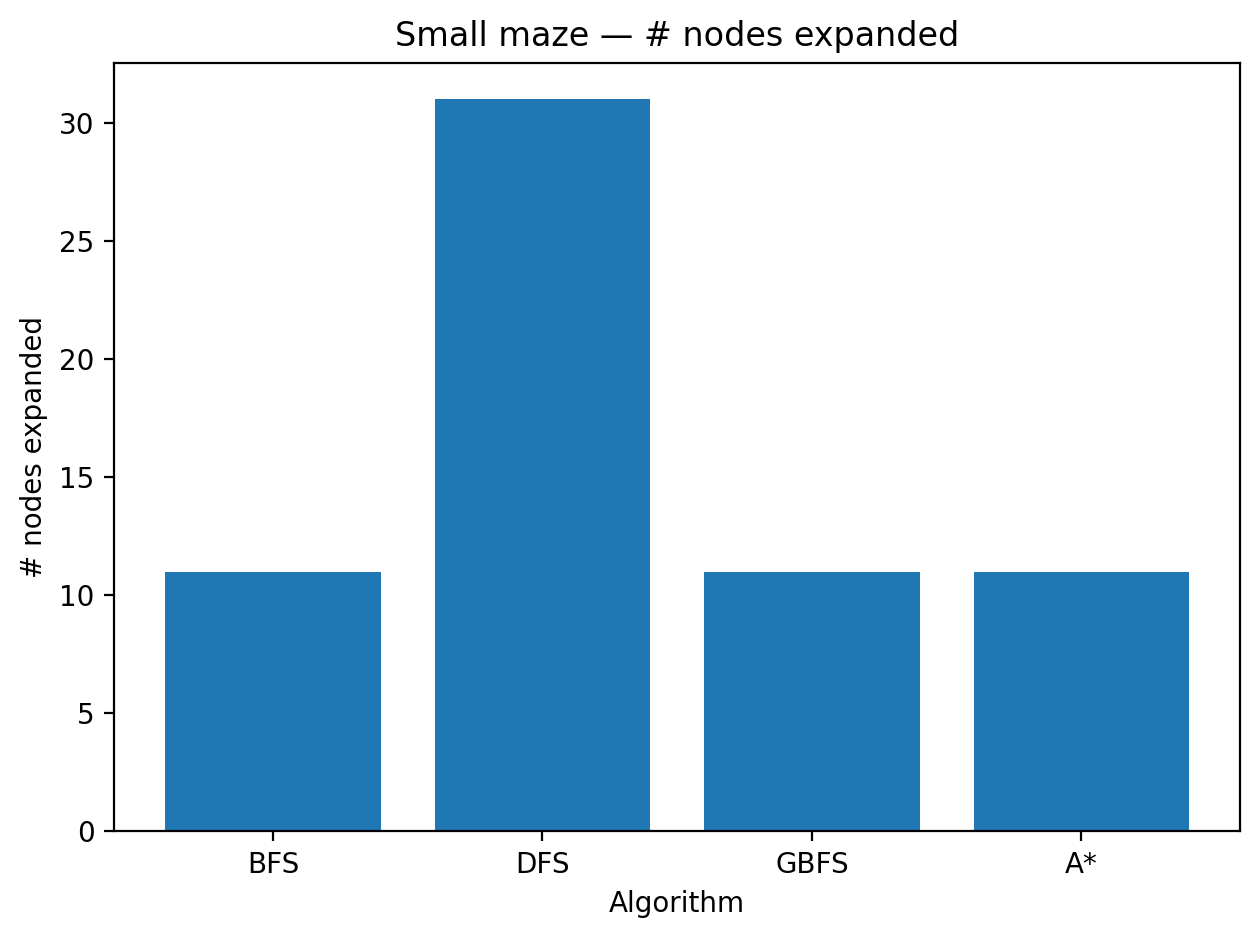

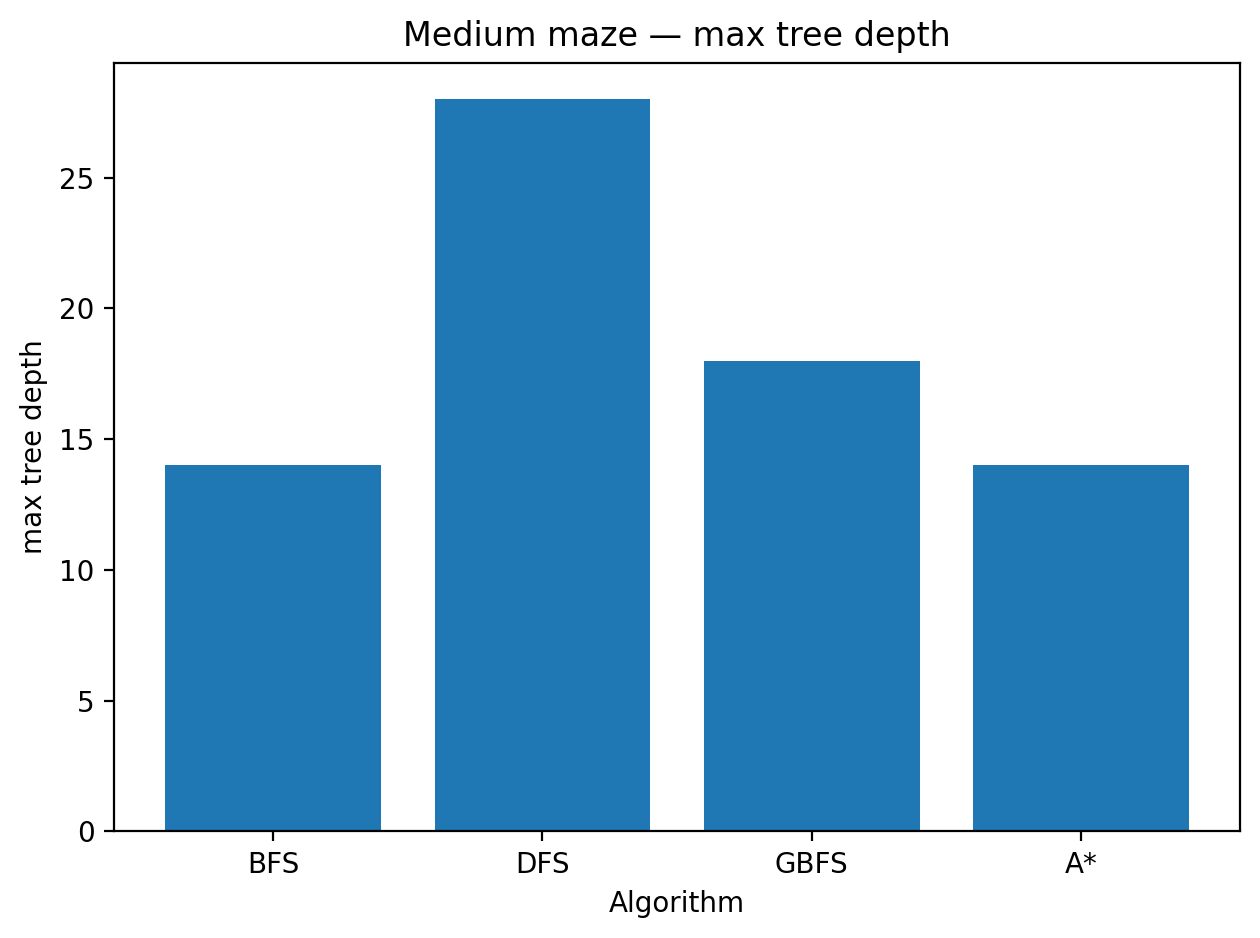

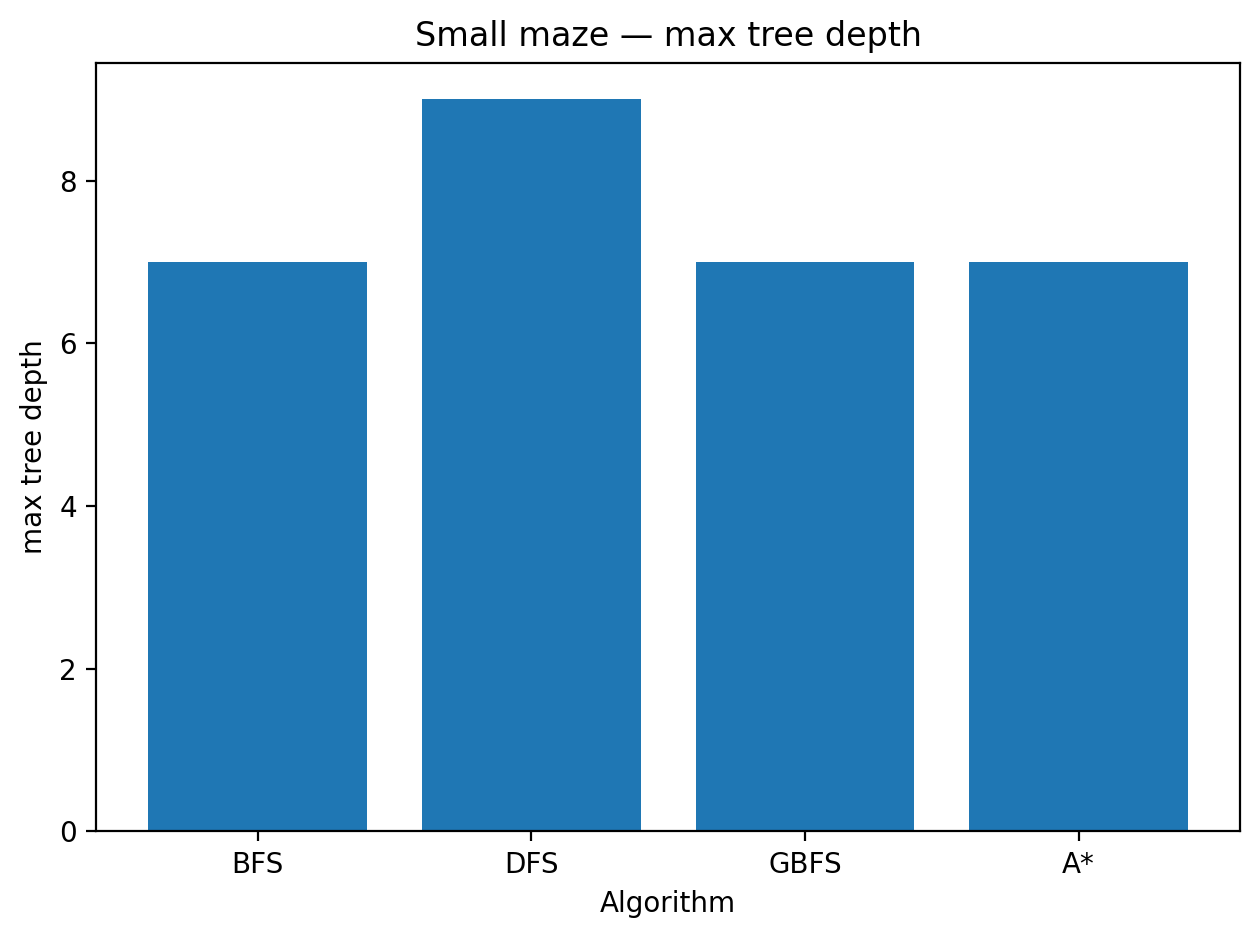

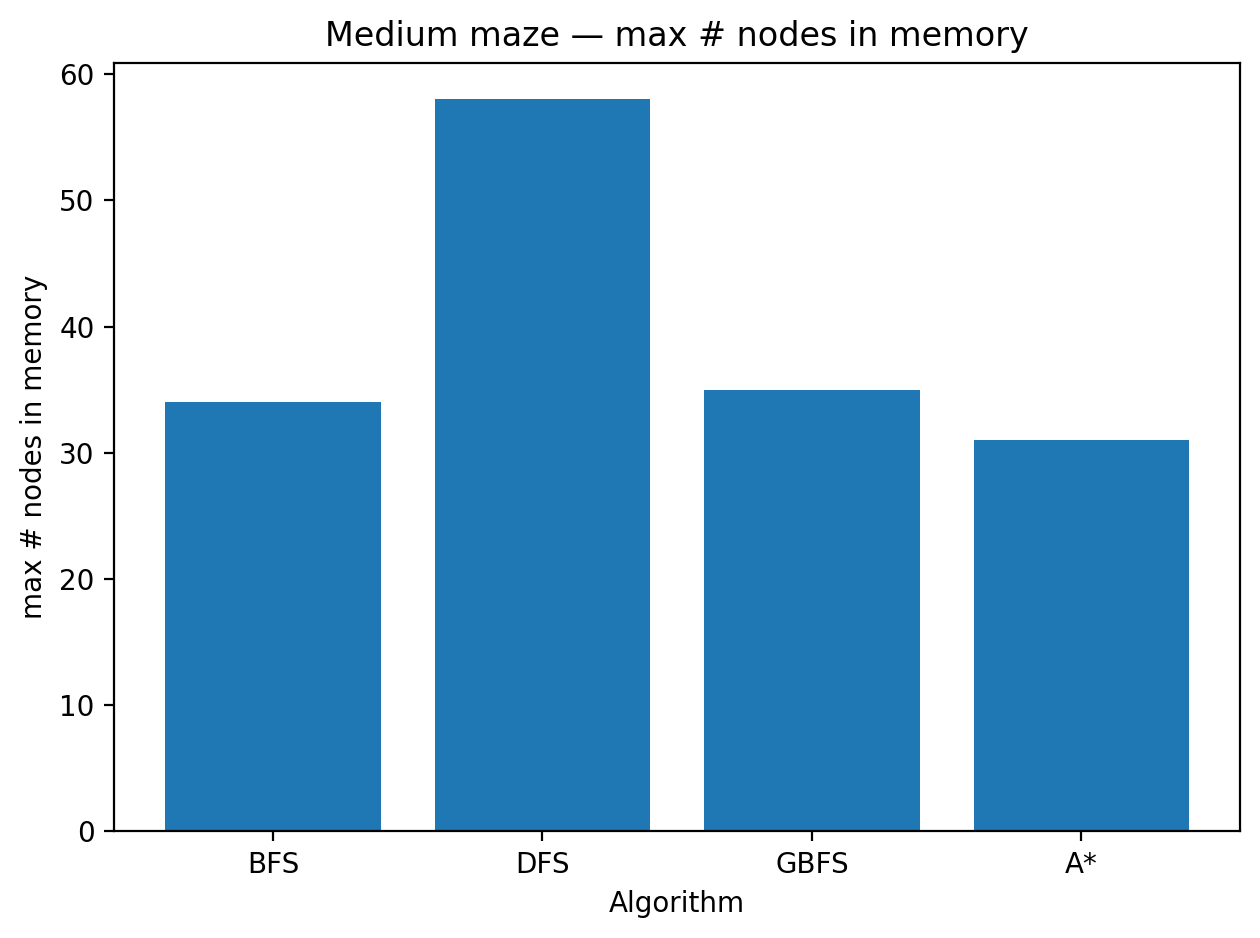

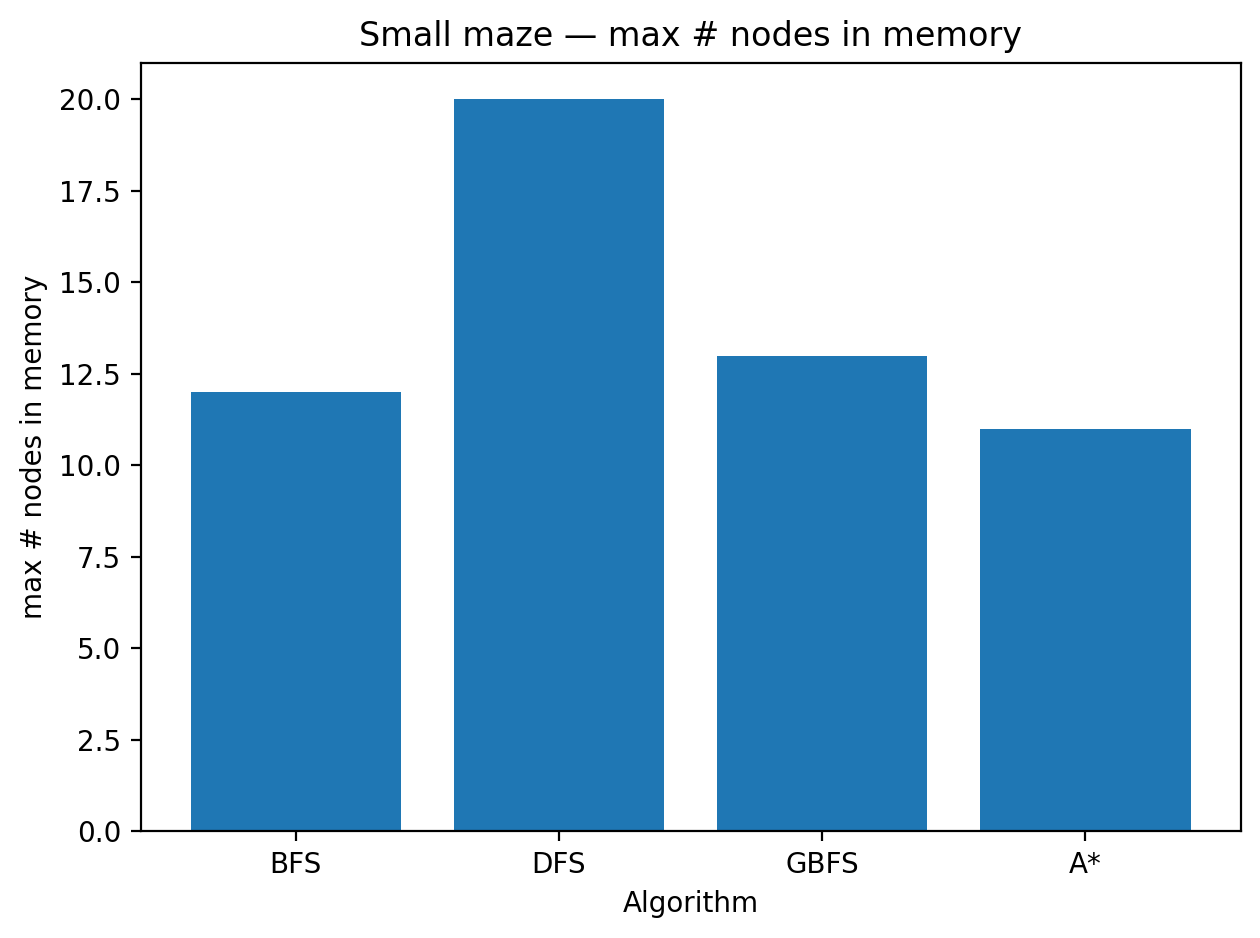

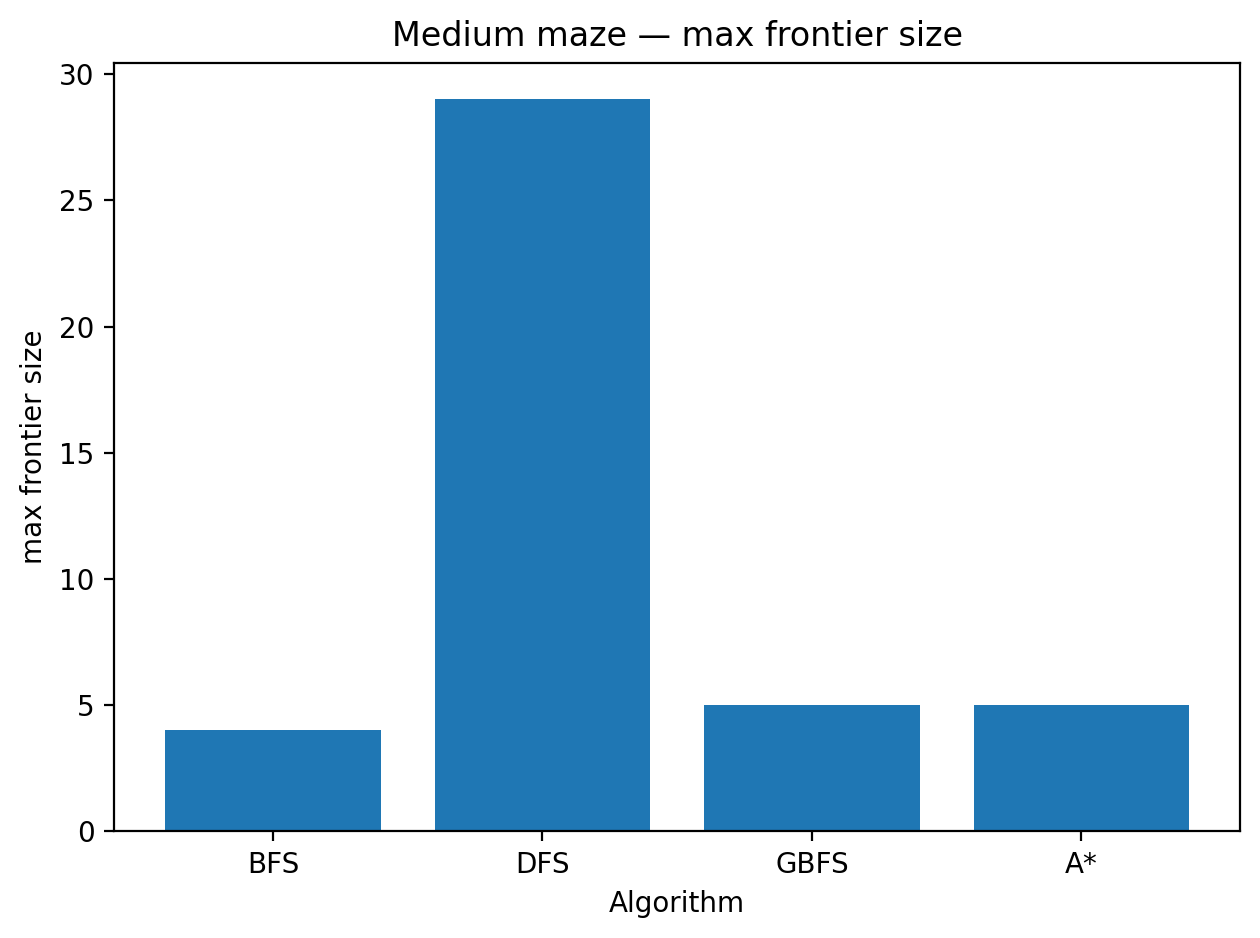

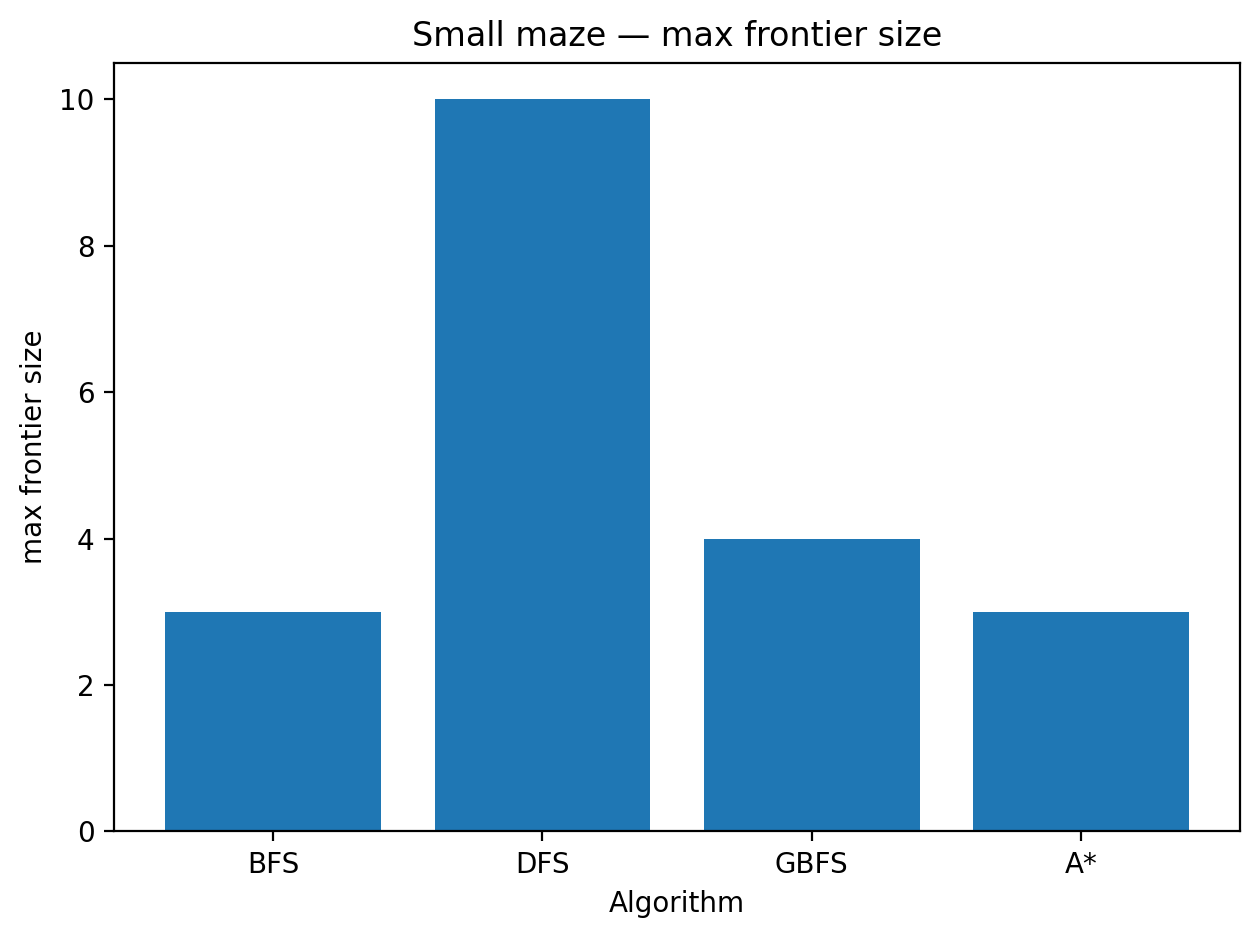

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(df, metric, title_suffix=""):
    # One chart per metric per maze, grouped by algorithm
    for maze_name, sub in df.groupby("maze"):
        plt.figure()
        x = range(len(sub))
        plt.bar(x, sub[metric])
        plt.xticks(x, sub["algorithm"], rotation=0)
        plt.title(f"{maze_name} — {metric}{(' — ' + title_suffix) if title_suffix else ''}")
        plt.xlabel("Algorithm")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()

# Produce charts
plot_metric(results_df, "path_cost")
plot_metric(results_df, "# nodes expanded")
plot_metric(results_df, "max tree depth")
plot_metric(results_df, "max # nodes in memory")
plot_metric(results_df, "max frontier size")

**Discuss** the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Discussion: Lessons Learned from Implementing Search Strategies

Implementing BFS, DFS, Greedy Best-First Search, and A* revealed key tradeoffs between **completeness, optimality, efficiency, and memory use**.

1. BFS
   - Guaranteed to find the shortest path in mazes with uniform cost.
   - However, it quickly consumes a lot of memory because it stores all frontier and visited states at each depth level.
   - Lesson: BFS is reliable but impractical for large or open search spaces due to its high space complexity.

2. DFS
   - Simple and memory-efficient since it only tracks the current path.
   - Not guaranteed to find the shortest path and can get stuck exploring long or looping branches.
   - Lesson: DFS is useful for deep exploration and small graphs but risky for finding optimal or guaranteed solutions.

3. Greedy Best-First Search
   - Uses the heuristic to guide the search toward the goal faster.
   - Performs well when the heuristic is accurate, but it can be misled by local minima or obstacles, missing the optimal path.
   - Lesson: A good heuristic can dramatically reduce search effort, but without considering path cost, the solution may be suboptimal.

4. A*
   - Combines the strengths of BFS and GBFS by balancing actual cost (g) and heuristic estimate (h).
   - With a consistent heuristic like Manhattan distance, A* is both complete and optimal.
   - Lesson: A* is the most powerful general-purpose search for pathfinding—efficient and optimal—but still limited by memory in large state spaces.

---

### Overall Takeaways
- There is no “best” search algorithm—each fits a specific situation:
  - BFS: small or shallow problems where optimality matters.
  - DFS: memory-limited or exploratory tasks.
  - GBFS: quick approximations where speed is preferred over accuracy.
  - A*: when both efficiency and optimality are required.
- The heuristic design (for GBFS and A*) is crucial; a poor heuristic reduces their advantage to brute-force behavior.
- Finally, implementing and visualizing these algorithms reinforced how small changes in **frontier management, cost tracking, and visited sets** can completely alter performance and correctness.


## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [ ]:
# Iterative Deepening Search (IDS)
# Builds on DFS, gradually increasing depth limit until goal is found.

def depth_limited_search(maze, start, goal, limit):
    from collections import deque
    stack = [(start, 0, [start])]  # (node, depth, path)
    visited = set()
    nodes_expanded = 0

    while stack:
        node, depth, path = stack.pop()
        nodes_expanded += 1
        visited.add(node)

        if node == goal:
            return path, nodes_expanded, True

        if depth < limit:
            for nb in neighbors(maze, node):
                if nb not in visited:
                    stack.append((nb, depth + 1, path + [nb]))

    return [], nodes_expanded, False

def iterative_deepening_search(maze, start, goal, max_depth=1000):
    total_expanded = 0
    for limit in range(max_depth):
        path, expanded, found = depth_limited_search(maze, start, goal, limit)
        total_expanded += expanded
        if found:
            return path, len(path) - 1, {
                "nodes_expanded": total_expanded,
                "max_tree_depth": limit,
                "algorithm": "IDS"
            }
    return [], float("inf"), {
        "nodes_expanded": total_expanded,
        "max_tree_depth": max_depth,
        "algorithm": "IDS",
        "note": "Goal not found within depth limit"
    }

# Example usage
maze, start, goal = parse_maze("""
S   #
##  # ###
    #   G
 #######

""")

path_ids, cost_ids, info_ids = iterative_deepening_search(maze, start, goal)
print("IDS Path Cost:", cost_ids)
print("Metrics:", info_ids)


# IDS Discussion
#Iterative Deepening Search (IDS) combines the advantages of BFS and DFS:
# It performs repeated depth-limited DFS runs, gradually increasing the depth limit.
# Like BFS, it is complete for finite graphs and finds the shortest path in terms of depth.
# Like DFS, it uses much less memory since it only stores one path at a time.
#However, IDS repeats work at shallow depths (nodes near the root are re-expanded many times).
#In large open mazes, this makes IDS slower than BFS, even though it saves memory.
#It may also perform poorly when there are many wide open areas, because every iteration explores large shallow layers again.


IDS Path Cost: inf
Metrics: {'nodes_expanded': 12943, 'max_tree_depth': 1000, 'algorithm': 'IDS', 'note': 'Goal not found within depth limit'}


### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [ ]:
# Multiple Goals: agent stops when it reaches ANY goal in a set

def find_multiple_goals(maze, start, goals, search_fn):
    """Runs the given search_fn (BFS, DFS, IDS) to reach any goal."""
    best_path, best_cost, best_info = [], float("inf"), None
    for goal in goals:
        path, cost, info = search_fn(maze, start, goal)
        if path and cost < best_cost:
            best_path, best_cost, best_info = path, cost, info
    return best_path, best_cost, best_info

# Example with two goals
maze_multi, start, _ = parse_maze("""
S #     #
# # ### # #
#   #     #
### # ### #
#   G #   G
# ### # ###
#     #
""")
goals = [(4, 4), (4, 8)]  # two goal locations 'G'

path_bfs, cost_bfs, info_bfs = find_multiple_goals(maze_multi, start, goals, bfs)
path_dfs, cost_dfs, info_dfs = find_multiple_goals(maze_multi, start, goals, dfs)
path_ids, cost_ids, info_ids = find_multiple_goals(maze_multi, start, goals, iterative_deepening_search)

print("BFS:", cost_bfs, info_bfs)
print("DFS:", cost_dfs, info_dfs)
print("IDS:", cost_ids, info_ids)

# Multiple Goals Discussion
#When multiple goals exist:
#- BFS still guarantees the shortest path because it explores level by level and will find the nearest goal first.
#- DFS may reach a goal quickly but not necessarily the closest one—it depends on the search order.
#- IDS behaves like BFS in terms of optimality (by depth) but can take longer due to repeated re-expansions.
#In summary:
#- BFS: fastest and optimal for multiple goals.
#- DFS: unpredictable and often non-optimal.
#- IDS: optimal but slower than BFS due to repeated depth iterations.



BFS: 8 {'nodes_expanded': 13, 'max_tree_depth': 8, 'max_nodes_in_memory': 18, 'max_frontier_size': 3, 'algorithm': 'BFS'}
DFS: 28 {'nodes_expanded': 29, 'max_tree_depth': 28, 'max_nodes_in_memory': 58, 'max_frontier_size': 29, 'algorithm': 'DFS'}
IDS: 8 {'nodes_expanded': 48, 'max_tree_depth': 8, 'algorithm': 'IDS'}


## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [ ]:
# Your code/answer goes here